The initial state is:  [ 390    0 1050    0  513    0 1278    0]
The measurement is:  [ 399 1022  504 1256]
The update state is:  [ 398    4 1022  -14  504   -4 1256  -11]


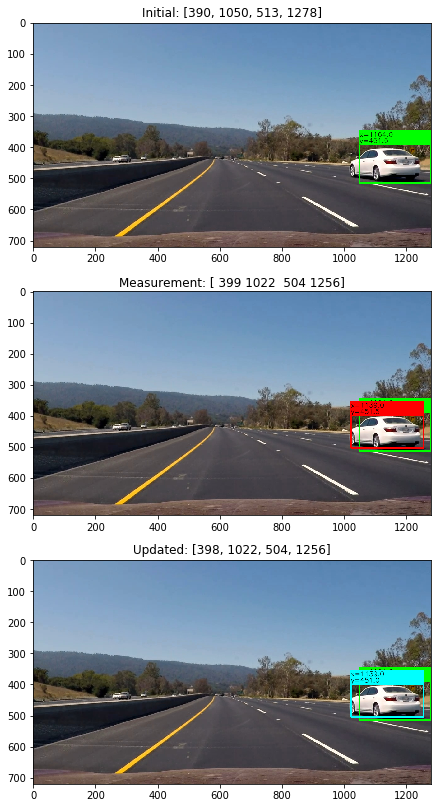

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
'''
Implement and test tracker
'''
import numpy as np
from numpy import dot
from scipy.linalg import inv, block_diag



class Tracker(): # class for Kalman Filter-based tracker
    def __init__(self):
        # Initialize parametes for tracker (history)
        self.id = 0  # tracker's id 
        self.box = [] # list to store the coordinates for a bounding box 
        self.hits = 0 # number of detection matches
        self.no_losses = 0 # number of unmatched tracks (track loss)
        
        # Initialize parameters for Kalman Filtering
        # The state is the (x, y) coordinates of the detection box
        # state: [up, up_dot, left, left_dot, down, down_dot, right, right_dot]
        # or[up, up_dot, left, left_dot, height, height_dot, width, width_dot]
        self.x_state=[] 
        self.dt = 1.   # time interval
        
        # Process matrix, assuming constant velocity model
        self.F = np.array([[1, self.dt, 0,  0,  0,  0,  0, 0],
                           [0, 1,  0,  0,  0,  0,  0, 0],
                           [0, 0,  1,  self.dt, 0,  0,  0, 0],
                           [0, 0,  0,  1,  0,  0,  0, 0],
                           [0, 0,  0,  0,  1,  self.dt, 0, 0],
                           [0, 0,  0,  0,  0,  1,  0, 0],
                           [0, 0,  0,  0,  0,  0,  1, self.dt],
                           [0, 0,  0,  0,  0,  0,  0,  1]])
        
        # Measurement matrix, assuming we can only measure the coordinates
        
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, 0], 
                           [0, 0, 0, 0, 0, 0, 1, 0]])
        
        
        # Initialize the state covariance
        self.L = 10.0
        self.P = np.diag(self.L*np.ones(8))
        
        
        # Initialize the process covariance
        self.Q_comp_mat = np.array([[self.dt**4/4., self.dt**3/2.],
                                    [self.dt**3/2., self.dt**2]])
        self.Q = block_diag(self.Q_comp_mat, self.Q_comp_mat, 
                            self.Q_comp_mat, self.Q_comp_mat)
        
        # Initialize the measurement covariance
        self.R_scaler = 1.0
        self.R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(self.R_diag_array)
        
        
    def update_R(self):   
        R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(R_diag_array)
        
        
        
        
    def kalman_filter(self, z): 
        '''
        Implement the Kalman Filter, including the predict and the update stages,
        with the measurement z
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        #Update
        S = dot(self.H, self.P).dot(self.H.T) + self.R
        K = dot(self.P, self.H.T).dot(inv(S)) # Kalman gain
        y = z - dot(self.H, x) # residual
        x += dot(K, y)
        self.P = self.P - dot(K, self.H).dot(self.P)
        self.x_state = x.astype(int) # convert to integer coordinates 
                                     #(pixel values)
        
    def predict_only(self):  
        '''
        Implment only the predict stage. This is used for unmatched detections and 
        unmatched tracks
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q
        self.x_state = x.astype(int)
        
if __name__ == "__main__":
    
    import matplotlib.pyplot as plt
    import glob
    import helpers
    
    # Creat an instance
    trk = Tracker() 
    # Test R_ratio   
    trk.R_scaler = 1.0/16
    # Update measurement noise covariance matrix
    trk.update_R()
    # Initial state
    x_init = np.array([390, 0, 1050, 0, 513, 0, 1278, 0])
    x_init_box = [x_init[0], x_init[2], x_init[4], x_init[6]]
    # Measurement
    z=np.array([399, 1022, 504, 1256])
    trk.x_state= x_init.T
    trk.kalman_filter(z.T)
    # Updated state
    x_update =trk.x_state
    x_updated_box = [x_update[0], x_update[2], x_update[4], x_update[6]]
    
    print('The initial state is: ', x_init)
    print('The measurement is: ', z)
    print('The update state is: ', x_update)
    
    # Visualize the Kalman filter process and the 
    # impact of measurement nosie convariance matrix
    
    images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
    img=images[3]

    plt.figure(figsize=(10, 14))
    helpers.draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    ax = plt.subplot(3, 1, 1)
    plt.imshow(img)
    plt.title('Initial: '+str(x_init_box))
    
    helpers.draw_box_label(img, z, box_color=(255, 0, 0))
    ax = plt.subplot(3, 1, 2)
    plt.imshow(img)
    plt.title('Measurement: '+str(z))
    
    helpers.draw_box_label(img, x_updated_box)
    ax = plt.subplot(3, 1, 3)
    plt.imshow(img)
    plt.title('Updated: '+str(x_updated_box))
    plt.show()    
